<a href="https://colab.research.google.com/github/OscarOvanger/GeoDecepticon/blob/main/training_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is where the training goes down

 We start of by installing the requirements

In [1]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

In [2]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

Cloning into 'GeoDecepticon'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 41 (delta 9), reused 11 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 2.51 MiB | 2.08 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [3]:
import os
os.chdir('/content/GeoDecepticon')

In [4]:
from dataloader import BinaryImageDataset, preprocess_image
from transformer import VisionTransformer
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sample import reconstruct_image_from_patches

training data shape:  (6000, 64, 64)
test data shape:  (3423, 64, 64)


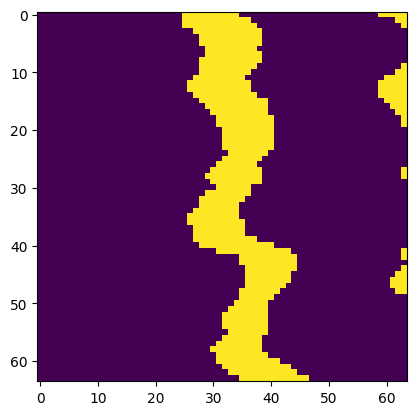

In [11]:
data_1 = np.load("data_array_1.npz")
data_2 = np.load("data_array_2.npz")
data_3 = np.load("data_array_3.npz")

data_array_1 = data_1['data_array']
data_array_2 = data_2['data_array']
data_array_3 = data_3['data_array']

training_data = np.concatenate((data_array_1, data_array_2), axis=0)
test_data = data_array_3
print("training data shape: ", training_data.shape)
print("test data shape: ", test_data.shape)

plt.imshow(training_data[0])
plt.show()

In [20]:
# Define the embedding matrix (16 embeddings of dimension 4)
embedding_matrix = torch.zeros((17, 4))

# Generate all possible 2x2 binary patches
patches = torch.tensor([
    [a, b, c, d]
    for a in range(2)
    for b in range(2)
    for c in range(2)
    for d in range(2)
])

# Calculate the embeddings
for i, patch in enumerate(patches):
    total_ones = patch.sum().item()
    if total_ones == 0:
        # Avoid division by zero, leave as zeros (or handle as needed)
        continue
    # Define the positions in the patch
    left_column = patch[::2].sum().item()
    right_column = patch[1::2].sum().item()
    lower_row = patch[2:].sum().item()
    upper_row = patch[:2].sum().item()

    # Fill the embedding matrix
    embedding_matrix[i, 0] = left_column / total_ones
    embedding_matrix[i, 1] = right_column / total_ones
    embedding_matrix[i, 2] = lower_row / total_ones
    embedding_matrix[i, 3] = upper_row / total_ones
embedding_matrix[-1,:] = torch.ones(4) # This is the masked embedding matrix
print("Embedding Matrix:\n", embedding_matrix)

Embedding Matrix:
 tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000],
        [0.3333, 0.6667, 0.6667, 0.3333],
        [1.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 0.5000, 0.5000],
        [1.0000, 0.0000, 0.5000, 0.5000],
        [0.6667, 0.3333, 0.6667, 0.3333],
        [0.5000, 0.5000, 0.0000, 1.0000],
        [0.3333, 0.6667, 0.3333, 0.6667],
        [0.6667, 0.3333, 0.3333, 0.6667],
        [0.5000, 0.5000, 0.5000, 0.5000],
        [1.0000, 1.0000, 1.0000, 1.0000]])


Epoch [1/100], Step [0/600], Loss: 0.5088
Epoch [1/100], Step [100/600], Loss: 0.5140
Epoch [1/100], Step [200/600], Loss: 0.4723
Epoch [1/100], Step [300/600], Loss: 0.5154
Epoch [1/100], Step [400/600], Loss: 0.4120
Epoch [1/100], Step [500/600], Loss: 0.4257
Epoch [1/100] completed. Average Loss: 0.4746


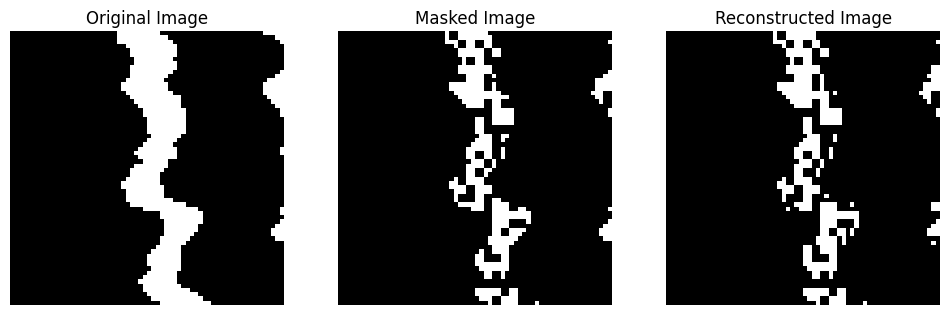

Epoch [2/100], Step [0/600], Loss: 0.4663
Epoch [2/100], Step [100/600], Loss: 0.4783
Epoch [2/100], Step [200/600], Loss: 0.5193
Epoch [2/100], Step [300/600], Loss: 0.4684
Epoch [2/100], Step [400/600], Loss: 0.5060
Epoch [2/100], Step [500/600], Loss: 0.3602
Epoch [2/100] completed. Average Loss: 0.4701


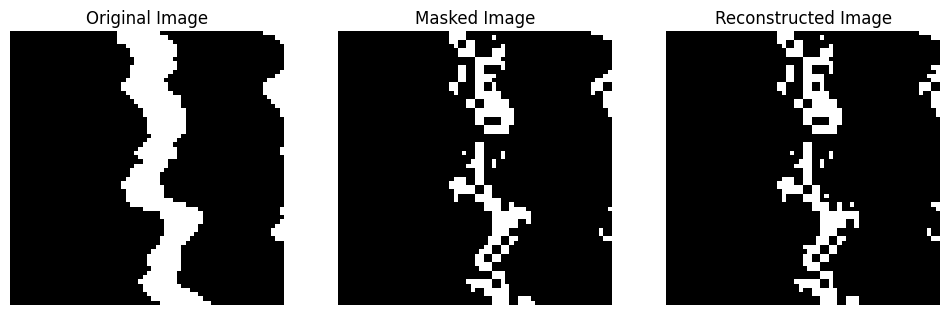

Epoch [3/100], Step [0/600], Loss: 0.5211
Epoch [3/100], Step [100/600], Loss: 0.4276
Epoch [3/100], Step [200/600], Loss: 0.4030
Epoch [3/100], Step [300/600], Loss: 0.3918
Epoch [3/100], Step [400/600], Loss: 0.4945
Epoch [3/100], Step [500/600], Loss: 0.4246
Epoch [3/100] completed. Average Loss: 0.4665


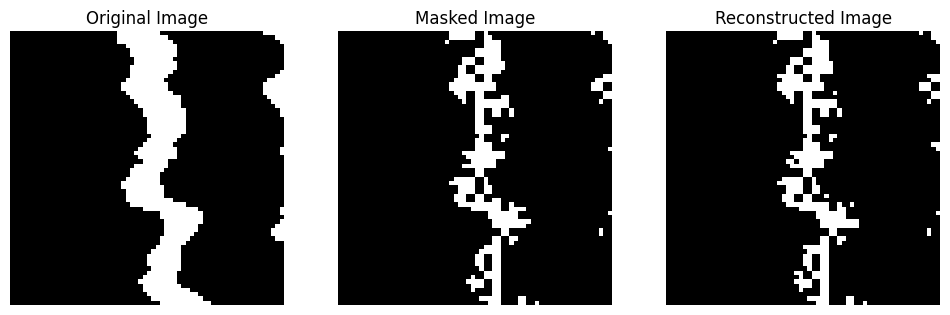

Epoch [4/100], Step [0/600], Loss: 0.4818
Epoch [4/100], Step [100/600], Loss: 0.5506
Epoch [4/100], Step [200/600], Loss: 0.4914
Epoch [4/100], Step [300/600], Loss: 0.4554
Epoch [4/100], Step [400/600], Loss: 0.5437


KeyboardInterrupt: 

In [18]:
# Convert to tensors, should be type Long
training_images = torch.tensor(training_data, dtype=torch.long)
test_images = torch.tensor(test_data, dtype=torch.long)

# Define the embedding layer using custom embeddings
embedding_matrix = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
# Parameters
batch_size = 10
embed_dim = 4
num_heads = 2
feedforward_dim = 8
num_layers = 2
num_tokens = 16 + 1 # One extra for the masked token
max_patches = 32 * 32
dropout = 0.0
learning_rate = 1e-4
num_epochs = 10

# Dataset and DataLoader
dataset = BinaryImageDataset(training_images)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
model = VisionTransformer(embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 100
# Directory to save checkpoints
os.makedirs("checkpoints", exist_ok=True)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, images in enumerate(dataloader):
        # Preprocess images
        patch_indices = torch.cat([preprocess_image(img) for img in images])
        patch_indices = patch_indices.long()
        masked_patches = patch_indices.clone()
        mask = torch.rand(masked_patches.shape) < 0.4  # Mask 40% of patches
        masked_patches[mask] = num_tokens  # Mask token index

        # Move inputs to the device
        masked_patches = masked_patches.to(device)
        mask = mask.to(device)
        patch_indices = patch_indices.to(device)

        # Forward pass
        logits = model(masked_patches.unsqueeze(0).long(), mask.unsqueeze(0))  # Add batch dim
        loss = criterion(logits.view(-1, num_tokens), patch_indices.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"checkpoints/vision_transformer_epoch_{epoch+1}.pth"
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": avg_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

    # Visualization after each epoch
    model.eval()
    with torch.no_grad():
        # Select a single image from the training set
        sample_image = training_images[0]  # Use the first image for simplicity
        original_image = sample_image.numpy()

        # Preprocess and mask the image
        patch_indices = preprocess_image(sample_image)
        patch_indices = patch_indices.long()
        masked_patches = patch_indices.clone()
        mask = torch.rand(masked_patches.shape) < 0.4
        masked_patches[mask] = num_tokens

        # Reconstruct the image using the model
        logits = model(masked_patches.unsqueeze(0).to(device).long(), mask.unsqueeze(0).to(device))
        predicted_indices = torch.argmax(logits, dim=-1).cpu().squeeze()  # Get predicted patches
        reconstructed_image = reconstruct_image_from_patches(predicted_indices)

        # Convert masked patches to image
        masked_image = reconstruct_image_from_patches(masked_patches)

        # Plot the original, masked, and reconstructed images
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(original_image, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Masked Image")
        plt.imshow(masked_image, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Reconstructed Image")
        plt.imshow(reconstructed_image, cmap="gray")
        plt.axis("off")

        plt.show()

# Save the final model
torch.save(model.state_dict(), "vision_transformer_final.pth")
print("Final model saved as 'vision_transformer_final.pth'.")

# Sampling